### This notebook looks at the impact of systematically deleting SC ... to the OUTER networks i.e., from ntwx A to ntwx B, C, etc

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59.8 s, sys: 0 ns, total: 59.8 s
Wall time: 1min 2s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.41 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [14]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 1min 31s


In [15]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

In [16]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is OUTER connectivity ... i.e., the average ntwx conn to other ntwx (so Vis to SomMot, DorsAttn, ..., DMN etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

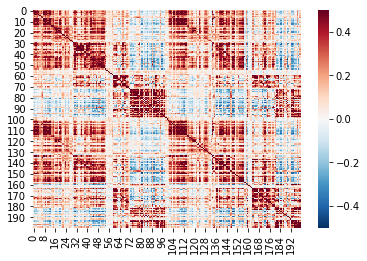

In [17]:
sns.heatmap(all_subs_emp_fc_mat[99], cmap='RdBu_r',center=0,vmax=0.5)

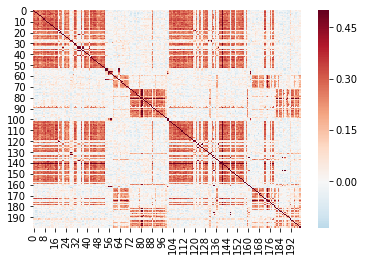

In [18]:
sns.heatmap(all_subs_og_whobpyt[99], cmap='RdBu_r',center=0,vmax=0.5)

In [19]:
i = 99

print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

0.6288580771510476


In [20]:
from numpy.polynomial.polynomial import polyfit

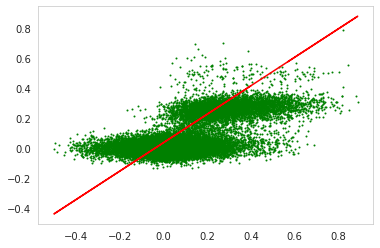

In [21]:
rww_test = all_subs_og_whobpyt[99][mask].flatten()

rww_test2 = all_subs_emp_fc_mat[99][mask].flatten()

m, b = np.polyfit(rww_test, rww_test2, 1)

sns.set_style('whitegrid')
fig,ax = plt.subplots()
plt.scatter(rww_test2, rww_test, color='green',s=1)
plt.plot(rww_test2, m*rww_test2 + b, color='red')
plt.grid(visible=False)

plt.show()

In [22]:
# for i in range(10):
#     print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

In [23]:
# for i in range(10):
#     rww_test = all_subs_og_whobpyt[i][mask].flatten()

#     rww_test2 = all_subs_emp_fc_mat[i][mask].flatten()

#     m, b = np.polyfit(rww_test, rww_test2, 1)

#     sns.set_style('whitegrid')
#     fig,ax = plt.subplots()
#     plt.scatter(rww_test2, rww_test, color='green',s=1)
#     plt.plot(rww_test2, m*rww_test2 + b, color='red')
#     plt.grid(visible=False)

#     plt.show()

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [25]:
# corrs_list

In [26]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [27]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [28]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [142]:
np.mean(all_subs_emp_fc_mat[77][30:43,43:54])

0.38016028409571956

#### divide by 2

In [29]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = ((np.mean(lh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/2 + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2)
    mean_ntwx_to_sommot_fc = ((np.mean(lh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/2 + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2)
    mean_ntwx_to_dorsattn_fc = ((np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/2 + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2)
    mean_ntwx_to_ventattn_fc = ((np.mean(lh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/2 + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2)
    mean_ntwx_to_limbic_fc = ((np.mean(lh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/2 + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2)
    mean_ntwx_to_fpn_fc = ((np.mean(lh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/2 + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2)
    mean_ntwx_to_dmn_fc = ((np.mean(lh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/2 + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2)
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    
#     if num == 0:
#         return mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 1:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 2:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 3:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 4:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 5:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_dmn_fc
#     elif num == 6:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc

#### divide by 4

In [30]:
# def outer_ntwx_only_fc(fc, sub, num):
    
#     a, b, c, d = ntwx_labels_idxs[num]
    
#     lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
#     lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
#     lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
#     lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
#     lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
#     lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
#     lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
#     lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
#     lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
#     lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
#     lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
#     lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
#     lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
#     lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
#     # ---------------------------------------------
    
#     rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
#     rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
#     rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
#     rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
#     rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
#     rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
#     rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
#     rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
#     rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
#     rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
#     rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
#     rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
#     rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
#     rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
#     mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))#/4
#     mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))#/4
#     mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))#/4
#     mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))#/4
#     mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))#/4
#     mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))#/4
#     mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))#/4
    
    
#     return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    
# #     if num == 0:
# #         return mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 1:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 2:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 3:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 4:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 5:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_dmn_fc
# #     elif num == 6:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc

### empirical data

In [31]:
%%time

empirical_vis_to_other_ntwx = []
empirical_sommot_to_other_ntwx = []
empirical_dorsattn_to_other_ntwx = []
empirical_ventattn_to_other_ntwx = []
empirical_limbic_to_other_ntwx = []
empirical_fpn_to_other_ntwx = []
empirical_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,0)
    empirical_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,1)
    empirical_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,2)
    empirical_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,3)
    empirical_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,4)
    empirical_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,5)
    empirical_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,6)
    empirical_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 862 ms, sys: 0 ns, total: 862 ms
Wall time: 827 ms


In [32]:
empirical_vis_to_other_ntwx = np.mean(empirical_vis_to_other_ntwx,axis=0)
empirical_sommot_to_other_ntwx = np.mean(empirical_sommot_to_other_ntwx,axis=0)
empirical_dorsattn_to_other_ntwx = np.mean(empirical_dorsattn_to_other_ntwx,axis=0)
empirical_ventattn_to_other_ntwx = np.mean(empirical_ventattn_to_other_ntwx,axis=0)
empirical_limbic_to_other_ntwx = np.mean(empirical_limbic_to_other_ntwx,axis=0)
empirical_fpn_to_other_ntwx = np.mean(empirical_fpn_to_other_ntwx,axis=0)
empirical_dmn_to_other_ntwx = np.mean(empirical_dmn_to_other_ntwx,axis=0)

In [33]:
# Across all 200 subs
empirical_outer_to_other_ntwx  = [empirical_vis_to_other_ntwx,empirical_sommot_to_other_ntwx,
                                   empirical_dorsattn_to_other_ntwx,empirical_ventattn_to_other_ntwx,
                                   empirical_limbic_to_other_ntwx,empirical_fpn_to_other_ntwx,
                                   empirical_dmn_to_other_ntwx]

### original WhoBPyT

In [34]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 851 ms, sys: 0 ns, total: 851 ms
Wall time: 815 ms


In [35]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [36]:
og_whobpyt_vis_to_other_ntwx_std = np.std(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx_std = np.std(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx_std = np.std(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx_std = np.std(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx_std = np.std(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx_std = np.std(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx_std = np.std(all_subs_dmn_to_other_ntwx,axis=0)

In [37]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

In [38]:
og_whobpyt_outer_to_other_ntwx_std = [og_whobpyt_vis_to_other_ntwx_std,og_whobpyt_sommot_to_other_ntwx_std,
                                      og_whobpyt_dorsattn_to_other_ntwx_std,og_whobpyt_ventattn_to_other_ntwx_std,
                                      og_whobpyt_limbic_to_other_ntwx_std,og_whobpyt_fpn_to_other_ntwx_std,
                                      og_whobpyt_dmn_to_other_ntwx_std]

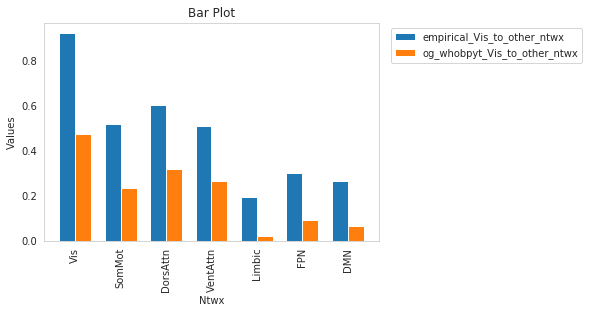

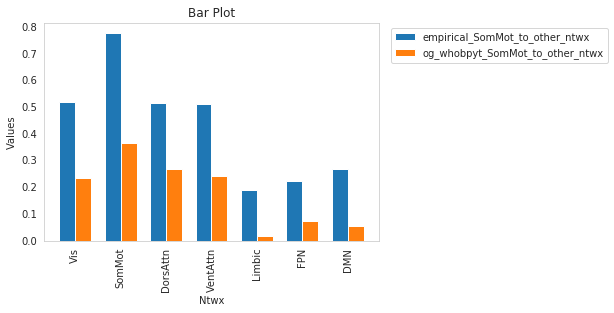

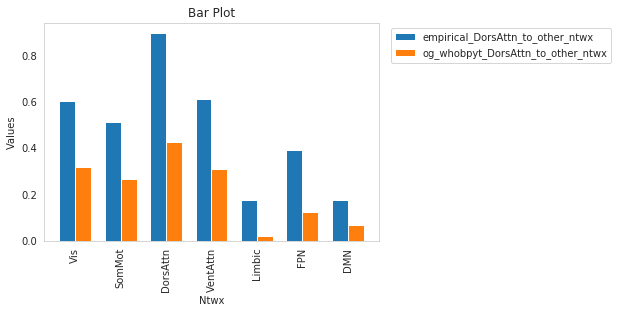

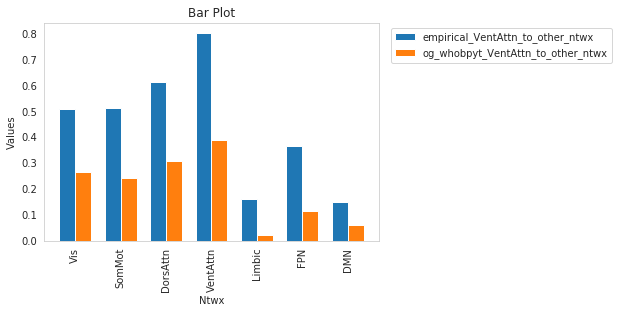

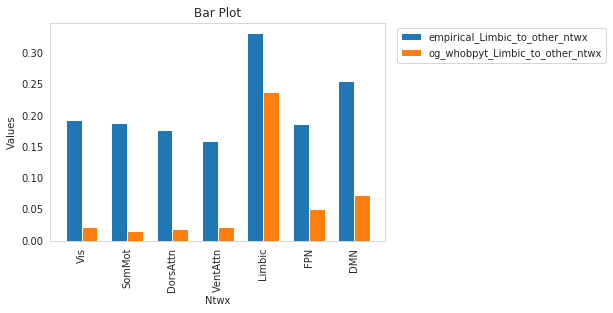

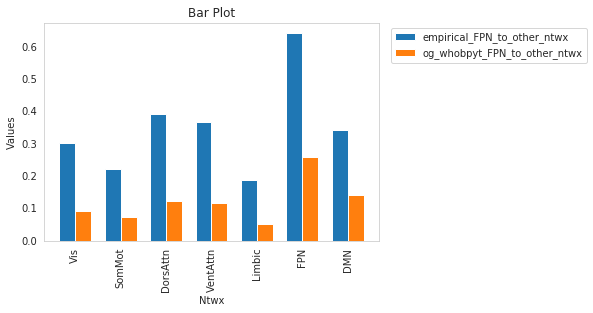

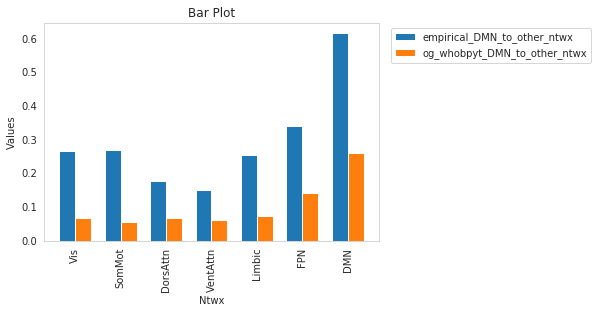

In [294]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, empirical_outer_to_other_ntwx[j], width, label='empirical_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], og_whobpyt_outer_to_other_ntwx[j], width, label='og_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    # Displaying the plot
    plt.show()

### Lesion WhoBPyT

In [40]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [41]:
def get_outer_ntwx_fc_std(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    std_all_subs_vis_to_other_ntwx_lesions = np.std(all_subs_vis_to_other_ntwx_lesions,axis=0)
    std_all_subs_sommot_to_other_ntwx_lesions = np.std(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    std_all_subs_dorsattn_to_other_ntwx_lesions = np.std(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    std_all_subs_ventattn_to_other_ntwx_lesions = np.std(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    std_all_subs_limbic_to_other_ntwx_lesions = np.std(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    std_all_subs_fpn_to_other_ntwx_lesions = np.std(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    std_all_subs_dmn_to_other_ntwx_lesions = np.std(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return std_all_subs_vis_to_other_ntwx_lesions,std_all_subs_sommot_to_other_ntwx_lesions,std_all_subs_dorsattn_to_other_ntwx_lesions,std_all_subs_ventattn_to_other_ntwx_lesions,std_all_subs_limbic_to_other_ntwx_lesions,std_all_subs_fpn_to_other_ntwx_lesions,std_all_subs_dmn_to_other_ntwx_lesions

In [42]:
def get_outer_ntwx_fc_all_subs(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    return all_subs_vis_to_other_ntwx_lesions,all_subs_sommot_to_other_ntwx_lesions,all_subs_dorsattn_to_other_ntwx_lesions,all_subs_ventattn_to_other_ntwx_lesions,all_subs_limbic_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [43]:
len(all_subs_vis_lesion)

200

# Mean

In [45]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.59 s, sys: 0 ns, total: 5.59 s
Wall time: 5.49 s


In [46]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [47]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]


vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

# Standard Deviation

In [47]:
vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_sommot_to_other_ntwx, vis_lesion_std_dorsattn_to_other_ntwx, vis_lesion_std_ventattn_to_other_ntwx, vis_lesion_std_limbic_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_vis_lesion)

sommot_lesion_std_vis_to_other_ntwx, sommot_lesion_std_sommot_to_other_ntwx, sommot_lesion_std_dorsattn_to_other_ntwx, sommot_lesion_std_ventattn_to_other_ntwx, sommot_lesion_std_limbic_to_other_ntwx, sommot_lesion_std_fpn_to_other_ntwx, sommot_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_sommot_lesion)

dorsattn_lesion_std_vis_to_other_ntwx, dorsattn_lesion_std_sommot_to_other_ntwx, dorsattn_lesion_std_dorsattn_to_other_ntwx, dorsattn_lesion_std_ventattn_to_other_ntwx, dorsattn_lesion_std_limbic_to_other_ntwx, dorsattn_lesion_std_fpn_to_other_ntwx, dorsattn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_dorsattn_lesion)

ventattn_lesion_std_vis_to_other_ntwx, ventattn_lesion_std_sommot_to_other_ntwx, ventattn_lesion_std_dorsattn_to_other_ntwx, ventattn_lesion_std_ventattn_to_other_ntwx, ventattn_lesion_std_limbic_to_other_ntwx, ventattn_lesion_std_fpn_to_other_ntwx, ventattn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_ventattn_lesion)

limbic_lesion_std_vis_to_other_ntwx, limbic_lesion_std_sommot_to_other_ntwx, limbic_lesion_std_dorsattn_to_other_ntwx, limbic_lesion_std_ventattn_to_other_ntwx, limbic_lesion_std_limbic_to_other_ntwx, limbic_lesion_std_fpn_to_other_ntwx, limbic_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_limbic_lesion)

fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_sommot_to_other_ntwx, fpn_lesion_std_dorsattn_to_other_ntwx, fpn_lesion_std_ventattn_to_other_ntwx, fpn_lesion_std_limbic_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_fpn_lesion)

dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_sommot_to_other_ntwx, dmn_lesion_std_dorsattn_to_other_ntwx, dmn_lesion_std_ventattn_to_other_ntwx, dmn_lesion_std_limbic_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_dmn_lesion)

In [48]:
vis_lesion_std_outer_to_other_ntwx = [vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_sommot_to_other_ntwx, vis_lesion_std_dorsattn_to_other_ntwx, vis_lesion_std_ventattn_to_other_ntwx, vis_lesion_std_limbic_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx]
sommot_lesion_std_outer_to_other_ntwx = [sommot_lesion_std_vis_to_other_ntwx, sommot_lesion_std_sommot_to_other_ntwx, sommot_lesion_std_dorsattn_to_other_ntwx, sommot_lesion_std_ventattn_to_other_ntwx, sommot_lesion_std_limbic_to_other_ntwx, sommot_lesion_std_fpn_to_other_ntwx, sommot_lesion_std_dmn_to_other_ntwx]
dorsattn_lesion_std_outer_to_other_ntwx = [dorsattn_lesion_std_vis_to_other_ntwx, dorsattn_lesion_std_sommot_to_other_ntwx, dorsattn_lesion_std_dorsattn_to_other_ntwx, dorsattn_lesion_std_ventattn_to_other_ntwx, dorsattn_lesion_std_limbic_to_other_ntwx, dorsattn_lesion_std_fpn_to_other_ntwx, dorsattn_lesion_std_dmn_to_other_ntwx]
ventattn_lesion_std_outer_to_other_ntwx = [ventattn_lesion_std_vis_to_other_ntwx, ventattn_lesion_std_sommot_to_other_ntwx, ventattn_lesion_std_dorsattn_to_other_ntwx, ventattn_lesion_std_ventattn_to_other_ntwx, ventattn_lesion_std_limbic_to_other_ntwx, ventattn_lesion_std_fpn_to_other_ntwx, ventattn_lesion_std_dmn_to_other_ntwx]
limbic_lesion_std_outer_to_other_ntwx = [limbic_lesion_std_vis_to_other_ntwx, limbic_lesion_std_sommot_to_other_ntwx, limbic_lesion_std_dorsattn_to_other_ntwx, limbic_lesion_std_ventattn_to_other_ntwx, limbic_lesion_std_limbic_to_other_ntwx, limbic_lesion_std_fpn_to_other_ntwx, limbic_lesion_std_dmn_to_other_ntwx]
fpn_lesion_std_outer_to_other_ntwx = [fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_sommot_to_other_ntwx, fpn_lesion_std_dorsattn_to_other_ntwx, fpn_lesion_std_ventattn_to_other_ntwx, fpn_lesion_std_limbic_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx]
dmn_lesion_std_outer_to_other_ntwx = [dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_sommot_to_other_ntwx, dmn_lesion_std_dorsattn_to_other_ntwx, dmn_lesion_std_ventattn_to_other_ntwx, dmn_lesion_std_limbic_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx]

In [49]:
og_whobpyt_outer_to_other_ntwx_std = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx_std]


vis_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in vis_lesion_std_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in sommot_lesion_std_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in dorsattn_lesion_std_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in ventattn_lesion_std_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in limbic_lesion_std_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in fpn_lesion_std_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in dmn_lesion_std_outer_to_other_ntwx]

### ------------------------------------------------------------------------------------------

In [48]:
%%time

# For stats

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_sommot_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dorsattn_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_ventattn_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_limbic_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dmn_lesion)


CPU times: user 5.5 s, sys: 0 ns, total: 5.5 s
Wall time: 5.45 s


In [49]:
og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_og_whobpyt)


In [53]:
# For stats

In [72]:
og_whobpyt_all_subs_outer_to_other_ntwx = [og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_outer_to_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_outer_to_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_outer_to_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_outer_to_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_outer_to_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_outer_to_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_outer_to_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

In [224]:
len(vis_lesion_outer_to_other_ntwx[0])

7

In [56]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [57]:
data = _var.copy()

In [58]:
len(og_whobpyt_outer_to_other_ntwx)

7

In [60]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [ ]:
# for dmn only

In [188]:
percent_change_all_ntwx_lesion = []

for i in range(7):
    percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],dmn_lesion_outer_to_other_ntwx[i])]
    percent_change_all_ntwx_lesion.append(percent_change_ntwx)

In [189]:
for j in range(7):
    if j!=6:
        del percent_change_all_ntwx_lesion[j][6]

In [190]:
percent_change_all_ntwx_lesion

[[2.300376982509585,
  2.4244304234587704,
  2.5927099381320966,
  2.365998781302487,
  -5.797723228658906,
  3.4137800054690683],
 [2.4244304234587704,
  2.422910932617127,
  2.387833796059675,
  2.665085062493846,
  -3.9016669305582896,
  4.6720917190898135],
 [2.5927099381320966,
  2.387833796059675,
  1.6007046335626895,
  2.2344152457303936,
  -2.596166387494198,
  4.1680326939445855],
 [2.365998781302487,
  2.665085062493846,
  2.2344152457303936,
  1.693035304009382,
  -4.664808005571607,
  3.1755834482635996],
 [-5.797723228658906,
  -3.901666930558334,
  -2.596166387494198,
  -4.664808005571592,
  -3.665343448780798,
  -29.75068518697468],
 [3.4137800054690235,
  4.6720917190898135,
  4.1680326939445855,
  3.1755834482635996,
  -29.75068518697468,
  -2.461711065777487],
 [-99.67385952907874,
  -102.17826923016682,
  -101.04553568302444,
  -100.1108851118863,
  -100.17056890450924,
  -99.4728557028044,
  -7.67392782027167]]

In [191]:
for i in range(4):
    print(np.mean(percent_change_all_ntwx_lesion[i][0:4]))
    print(np.std(percent_change_all_ntwx_lesion[i][0:4]))
    print('---')

2.4208790313507347
0.10847932813615122
---
2.475065053657355
0.11068063762140047
---
2.2039159033712137
0.37073597027566857
---
2.239633598384027
0.3520561156921199
---


In [192]:
np.mean([2.4208790313507347, 2.475065053657355, 2.2039159033712137, 2.239633598384027])

2.3348733966908326

In [193]:
np.std([0.10847932813615122,0.11068063762140047,0.37073597027566857,0.3520561156921199])

0.12608352340038406

In [220]:
len(og_whobpyt_outer_to_other_ntwx[0])

7

In [213]:
# not means ... individual 7x7 values ...

def mean_percent_drops_all_vals(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
       
    return percent_change_all_ntwx_lesion

In [214]:
percent_change_vis = mean_percent_drops_all_vals(vis_lesion_outer_to_other_ntwx,0)
percent_change_smt = mean_percent_drops_all_vals(sommot_lesion_outer_to_other_ntwx,1)
percent_change_dan = mean_percent_drops_all_vals(dorsattn_lesion_outer_to_other_ntwx,2)
percent_change_van = mean_percent_drops_all_vals(ventattn_lesion_outer_to_other_ntwx,3)
percent_change_lim = mean_percent_drops_all_vals(limbic_lesion_outer_to_other_ntwx,4)
percent_change_fpn = mean_percent_drops_all_vals(fpn_lesion_outer_to_other_ntwx,5)
percent_change_dmn = mean_percent_drops_all_vals(dmn_lesion_outer_to_other_ntwx,6)

In [216]:
percent_change_all_ntwx_all_vals = [percent_change_vis,percent_change_smt,percent_change_dan,
                                    percent_change_van,percent_change_lim,percent_change_fpn,
                                    percent_change_dmn]

In [217]:
Ntwx_labels

['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [218]:
for i in range(7):
    print(Ntwx_labels[i], 'lesion')
    for j in range(7):
        print(percent_change_all_ntwx_all_vals[i][j])
        print('')
    print('------------------------------------------------------------------------')

Vis lesion
[-7.204290046660875, -100.41106908836335, -100.37337536310977, -100.21918263431009, -106.49439101507829, -98.1729014945464, -97.85126443951116]

[-100.41106908836335, -9.243018996230921, -24.741740937036752, -19.51465978067462, -19.936296380683636, -20.576582235777245, -32.78395885757253]

[-100.37337536310977, -24.741740937036752, -20.351230618682926, -24.900310797126522, -23.620412326556337, -16.695461240050722, -30.256801128290554]

[-100.21918263431009, -19.51465978067462, -24.90031079712654, -13.489962088321269, -10.90682554872369, -13.953744866106796, -23.09563564117849]

[-106.49439101507832, -19.936296380683643, -23.620412326556327, -10.906825548723692, 1.868536695848228, 3.5141990283790605, 3.8492927712848015]

[-98.1729014945464, -20.576582235777245, -16.69546124005071, -13.953744866106796, 3.5141990283790605, 1.5164588474047285, 1.355622916664146]

[-97.85126443951116, -32.78395885757254, -30.256801128290572, -23.09563564117848, 3.8492927712847824, 1.3556229166642

In [276]:
percent_change_all_ntwx_all_vals = np.array(percent_change_all_ntwx_all_vals)

In [286]:
import numpy.ma as ma

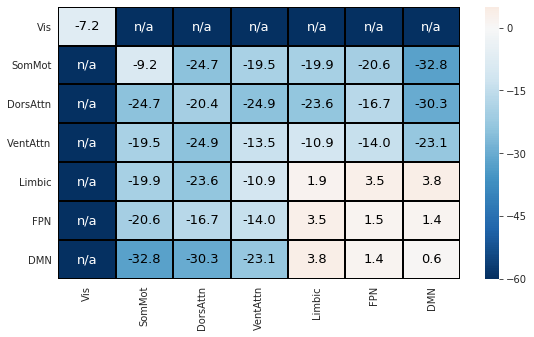

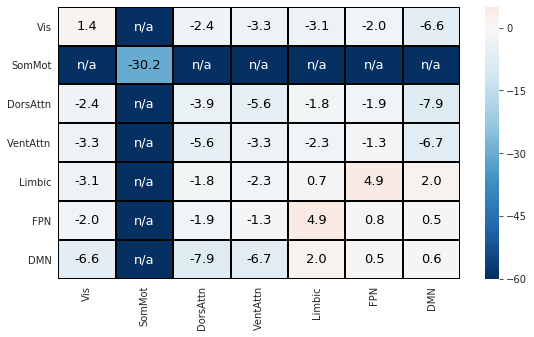

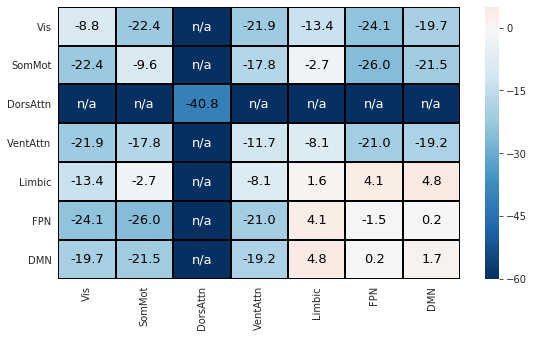

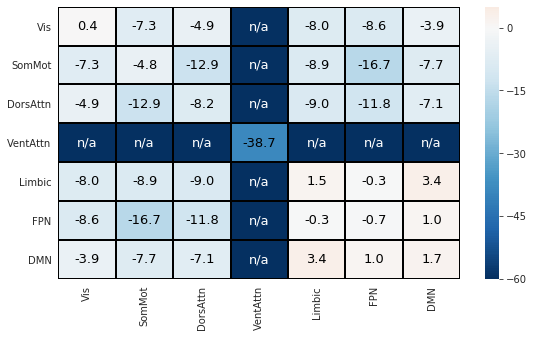

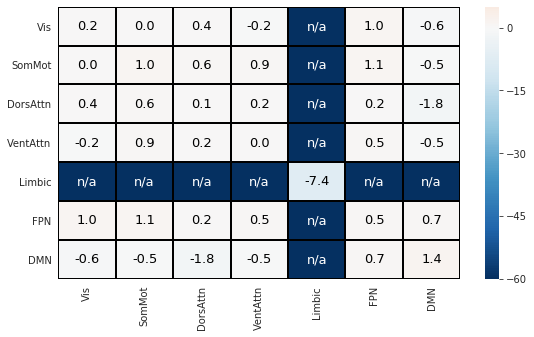

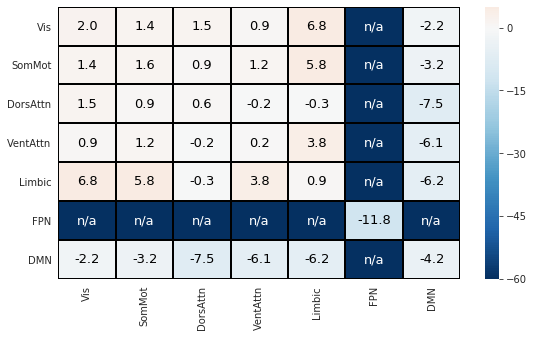

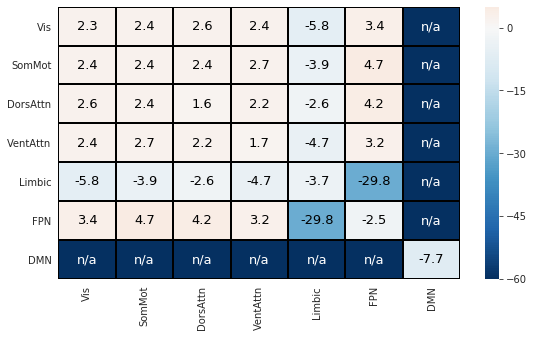

In [291]:
for i in range(7):
    fig, ax = plt.subplots(figsize=(9,5))
    
    sns.heatmap(percent_change_all_ntwx_all_vals[i,:,:],cmap='RdBu_r',center=0, vmin=-60, vmax = 5,linewidths=1, linecolor='black')
    # Annotate each cell with the corresponding value
    for x in range(len(Ntwx_labels)):
        for y in range(len(Ntwx_labels)):
            value = percent_change_all_ntwx_all_vals[i, x, y]
            if value > -90:
                ax.text(y + 0.5, x + 0.5, f'{value:.1f}', ha='center', va='center', color='black', fontsize=13)
            elif value <= -90:
                ax.text(y + 0.5, x + 0.5, 'n/a', ha='center', va='center', color='white', fontsize=13)
    ax.set_xticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_xticklabels(Ntwx_labels, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_yticklabels(Ntwx_labels, rotation=0, ha='right')
    plt.show()


In [168]:
def mean_percent_drops(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
    for j in range(7):
        if j!=idx:
            del percent_change_all_ntwx_lesion[j][idx]
    
    percent_drop_means = []
    for k in range(7):
        if k!=idx:
            percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
    percent_drop_stds = []
    for m in range(7):
        if m!=idx:
            percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
    return percent_drop_means, percent_drop_stds

In [202]:
percent_change_vis_mean, percent_change_vis_std = mean_percent_drops(vis_lesion_outer_to_other_ntwx,0)
percent_change_smt_mean, percent_change_smt_std = mean_percent_drops(sommot_lesion_outer_to_other_ntwx,1)
percent_change_dan_mean, percent_change_dan_std = mean_percent_drops(dorsattn_lesion_outer_to_other_ntwx,2)
percent_change_van_mean, percent_change_van_std = mean_percent_drops(ventattn_lesion_outer_to_other_ntwx,3)
percent_change_lim_mean, percent_change_lim_std = mean_percent_drops(limbic_lesion_outer_to_other_ntwx,4)
percent_change_fpn_mean, percent_change_fpn_std = mean_percent_drops(fpn_lesion_outer_to_other_ntwx,5)
percent_change_dmn_mean, percent_change_dmn_std = mean_percent_drops(dmn_lesion_outer_to_other_ntwx,6)

In [203]:
print(percent_change_vis_mean, '\n')
print('---')
print(percent_change_smt_mean, '\n')
print('---')
print(percent_change_dan_mean, '\n')
print('---')
print(percent_change_van_mean, '\n')
print('---')
print(percent_change_lim_mean, '\n')
print('---')
print(percent_change_fpn_mean, '\n')
print('---')
print(percent_change_dmn_mean, '\n')
print('---')

[-21.132709531329287, -23.4276595079573, -17.643523120355237, -7.538584293408596, -7.473251258247803, -13.385069824204377] 

---
[-2.667010903158438, -3.9353977532279765, -3.7593354571435253, 0.03664549142286152, 0.1597654380525604, -3.027681000261135] 

---
[-18.3747337369281, -16.660020501539606, -16.605742960764392, -2.280242179967999, -11.382097531966993, -8.938479289720219] 

---
[-5.377463436047633, -9.727313921101441, -8.979039954573365, -3.568761165201621, -6.193113213649149, -2.109471507719386] 

---
[0.12676062836225407, 0.5304071449577282, -0.07153324922882676, 0.15919077191348374, 0.6739613505056316, -0.2099751331393952] 

---
[1.7501109331841154, 1.279610334109422, -0.828909505602787, -0.036100733009599185, 1.789934449634723, -4.9036589907136445] 

---
[1.2165954837021833, 1.778447500526824, 1.731254986655874, 1.2448849727046836, -8.396065531339751, -2.7971513976641904] 

---


In [201]:
print(percent_change_vis_std, '\n')
print('---')
print(percent_change_smt_std, '\n')
print('---')
print(percent_change_dan_std, '\n')
print('---')
print(percent_change_van_std, '\n')
print('---')
print(percent_change_lim_std, '\n')
print('---')
print(percent_change_fpn_std, '\n')
print('---')
print(percent_change_dmn_std, '\n')
print('---')

[7.0059525471982695, 4.190400716131958, 5.198353548817659, 11.284319471034294, 9.816917437412522, 15.629834070661156] 

---
[2.3643312047377925, 2.202489759174775, 1.8592412629011432, 2.7794402891338192, 2.365422770098013, 4.100241168879997] 

---
[5.491639761948611, 8.062368475277475, 5.032555479986027, 6.626107546511981, 12.514825335552299, 11.267480750912046] 

---
[3.081542658909089, 3.964531489110353, 2.716206127532891, 5.20230124714368, 6.636327731528691, 4.362288340553339] 

---
[0.4994167498665294, 0.5692228730343543, 0.7990239161666838, 0.4356261333271482, 0.3177131826547508, 1.0374135788116927] 

---
[2.663401253900847, 2.5905959179373017, 3.064682160559431, 2.9872797653209147, 4.346389704253648, 1.8492698207540585] 

---
[3.1590228798461903, 2.665426222618682, 2.0859799995675825, 2.680358839426862, 9.599580080800663, 12.2824951085486] 

---


In [175]:
print('LONs <-> LONs')
print(np.mean(percent_change_vis_mean[0:3]), '\n')
print('---')
print(np.mean(percent_change_smt_mean[0:3]), '\n')
print('---')
print(np.mean(percent_change_dan_mean[0:3]), '\n')
print('---')
print(np.mean(percent_change_van_mean[0:3]), '\n')
print('---')

print('LONs <-> HONs')
print(np.mean(percent_change_vis_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_smt_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_dan_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_van_mean[4:6]), '\n')
print('---')


print('==========================================================================')

print('HONs <-> LONs')
print(np.mean(percent_change_lim_mean[0:4]), '\n')
print('---')
print(np.mean(percent_change_fpn_mean[0:4]), '\n')
print('---')
print(np.mean(percent_change_dmn_mean[0:4]), '\n')
print('---')

print('HONs <-> HONs')
print(np.mean(percent_change_lim_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_fpn_mean[4:6]), '\n')
print('---')
print(np.mean(percent_change_dmn_mean[4:6]), '\n')
print('---')

LONs <-> LONs
-20.73463071988061 

---
-3.45391470450998 

---
-17.2134990664107 

---
-8.02793910390748 

---
LONs <-> HONs
-10.42916054122609 

---
-1.4339577811042872 

---
-10.160288410843606 

---
-4.151292360684268 

---
HONs <-> LONs
0.18620632400115983 

---
0.5411777571702878 

---
1.4927957358973913 

---
HONs <-> HONs
0.23199310868311818 

---
-1.5568622705394608 

---
-5.596608464501971 

---


In [179]:
print('LON <-> LON ', np.mean([-20.73463071988061,-3.45391470450998,-17.2134990664107,-8.02793910390748]))
print('LON <-> LON ', np.std([-20.73463071988061,-3.45391470450998,-17.2134990664107,-8.02793910390748]))

LON <-> LON  -12.357495898677191
LON <-> LON  6.924160142174668


In [180]:
print('LON <-> HON ', np.mean([-10.42916054122609,-1.4339577811042872,-10.160288410843606,-4.151292360684268]))
print('LON <-> HON ', np.std([-10.42916054122609,-1.4339577811042872,-10.160288410843606,-4.151292360684268]))

LON <-> HON  -6.543674773464563
LON <-> HON  3.873293017722428


In [165]:
def mean_percent_drops(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
#     percent_drop_means = []
#     for k in range(7):
#         if k!=idx:
#             percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
#     percent_drop_stds = []
#     for m in range(7):
#         if m!=idx:
#             percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
#     return percent_drop_means, percent_drop_stds

    return percent_change_all_ntwx_lesion

In [166]:
percent_change_vis = mean_percent_drops(vis_lesion_outer_to_other_ntwx,0)
percent_change_smt = mean_percent_drops(sommot_lesion_outer_to_other_ntwx,1)
percent_change_dan = mean_percent_drops(dorsattn_lesion_outer_to_other_ntwx,2)
percent_change_van = mean_percent_drops(ventattn_lesion_outer_to_other_ntwx,3)
percent_change_lim = mean_percent_drops(limbic_lesion_outer_to_other_ntwx,4)
percent_change_fpn = mean_percent_drops(fpn_lesion_outer_to_other_ntwx,5)
percent_change_dmn = mean_percent_drops(dmn_lesion_outer_to_other_ntwx,6)

In [167]:
print(percent_change_vis[0][0])
print(percent_change_smt[1][1])
print(percent_change_dan[2][2])
print(percent_change_van[3][3])
print(percent_change_lim[4][4])
print(percent_change_fpn[5][5])
print(percent_change_dmn[6][6])

-7.204290046660875
-30.18575912497812
-40.7509831829247
-38.70099387333142
-7.3690447239169625
-11.825371779878797
-7.67392782027167


In [177]:
np.mean([-7.204290046660875,
-30.18575912497812,
-40.7509831829247,
-38.70099387333142])

-29.210506556973776

In [178]:
np.std([-7.204290046660875,
-30.18575912497812,
-40.7509831829247,
-38.70099387333142])

13.308612182776912

In [ ]:
-7.3690447239169625
-11.825371779878797
-7.67392782027167

In [181]:
np.mean([-7.3690447239169625,
-11.825371779878797,
-7.67392782027167])

-8.956114774689143

In [182]:
np.std([-7.3690447239169625,
-11.825371779878797,
-7.67392782027167])

2.0326854563988555

#### Visual

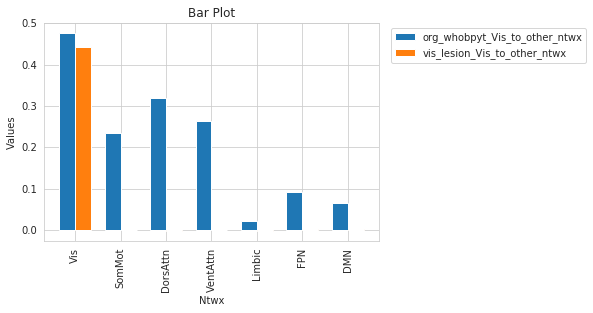

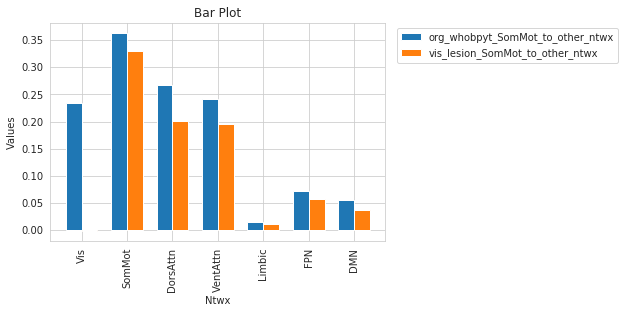

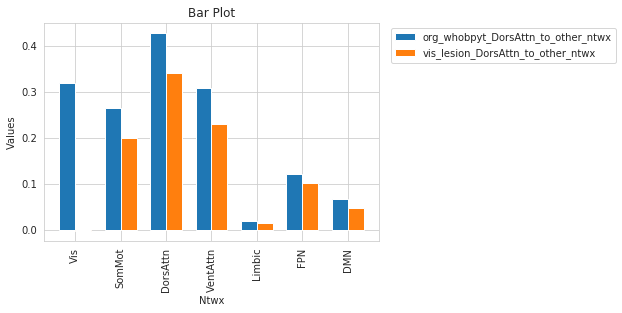

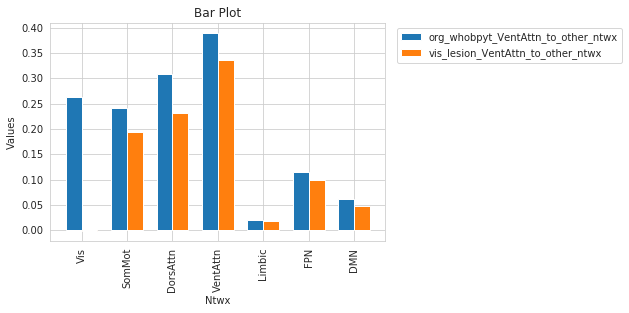

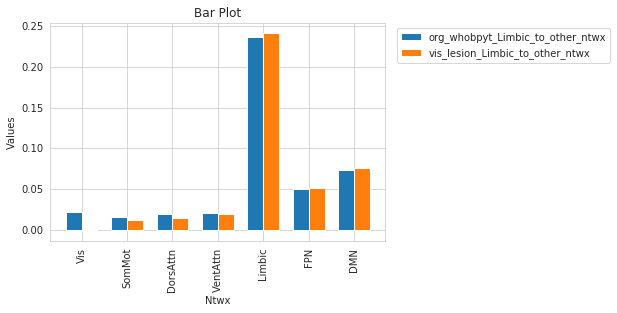

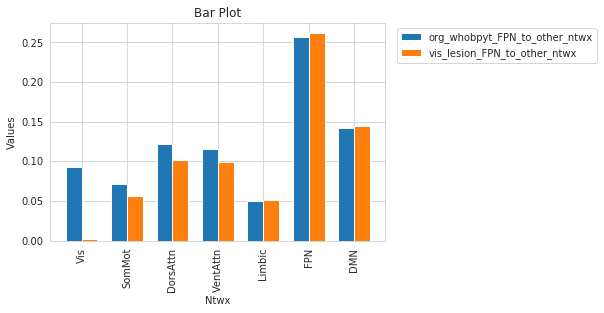

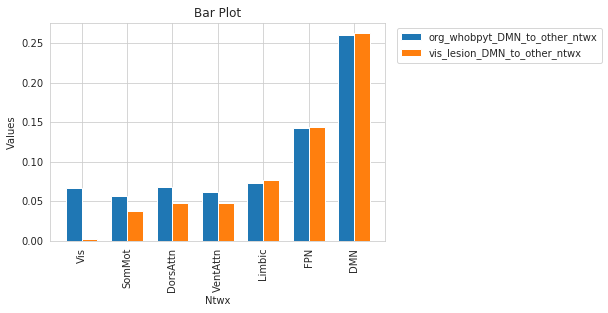

In [61]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx[j], width, label='vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

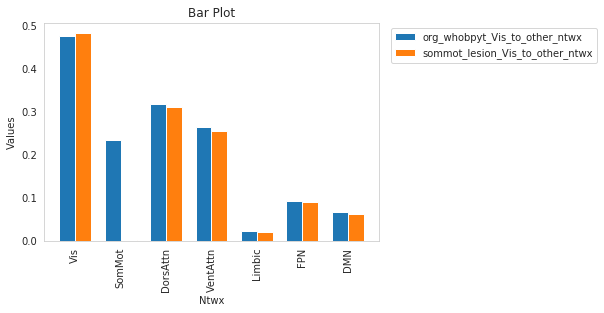

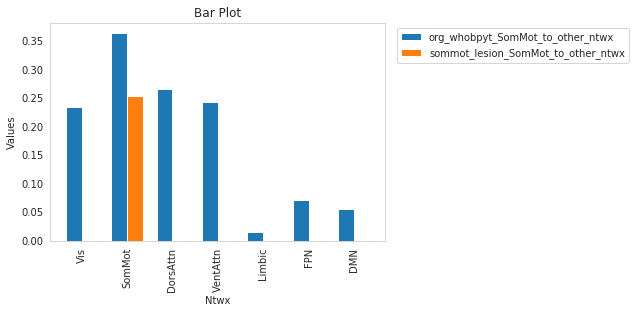

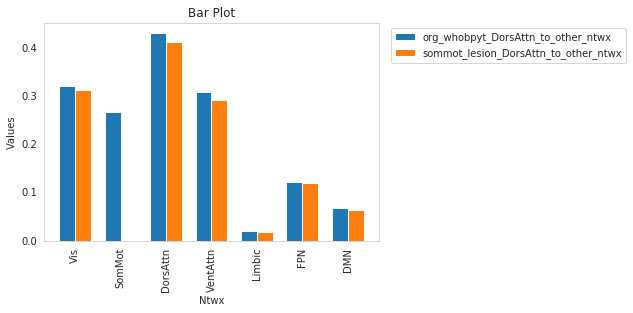

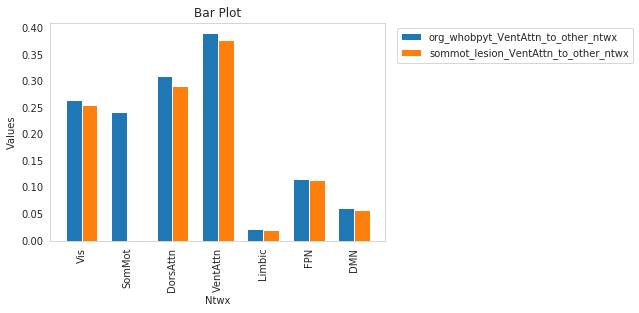

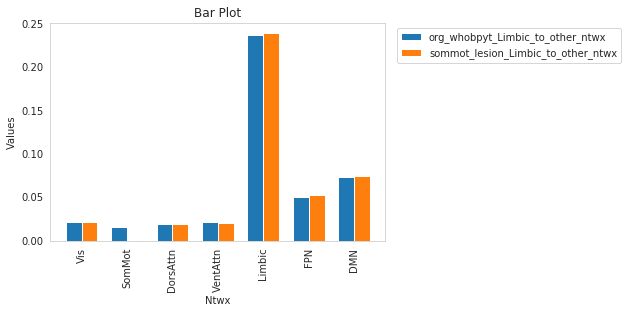

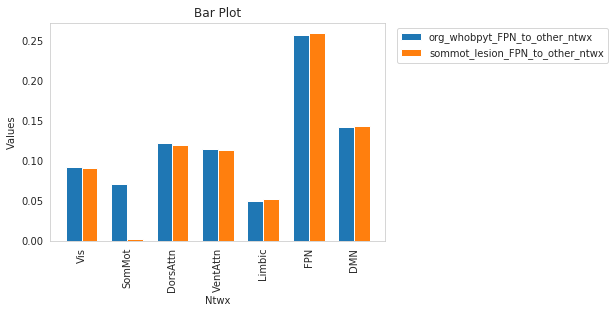

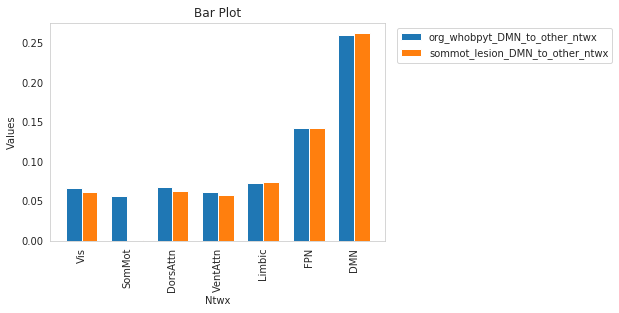

In [293]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx[j], width, label='sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    # Displaying the plot
    plt.show()

#### DorsAttn

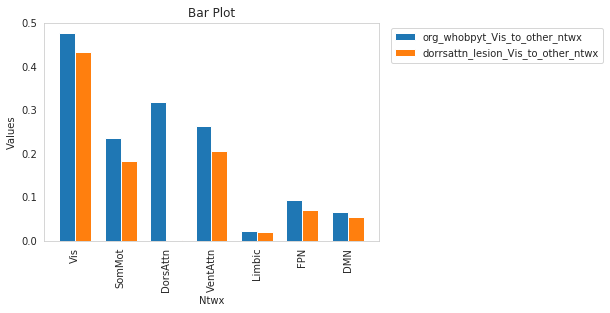

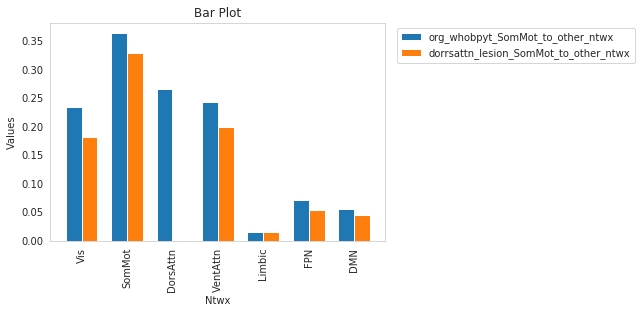

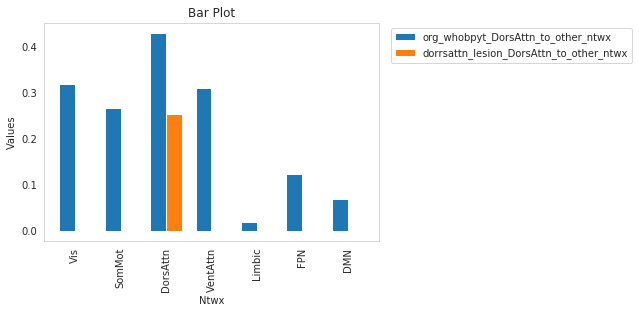

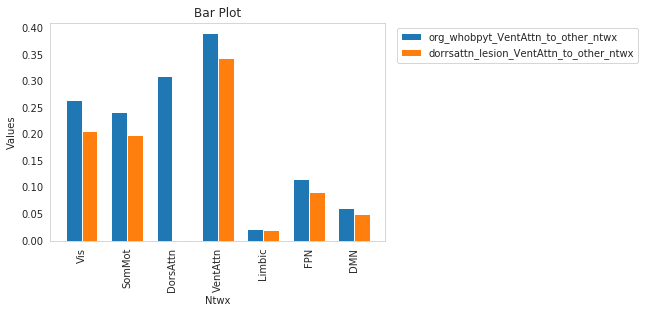

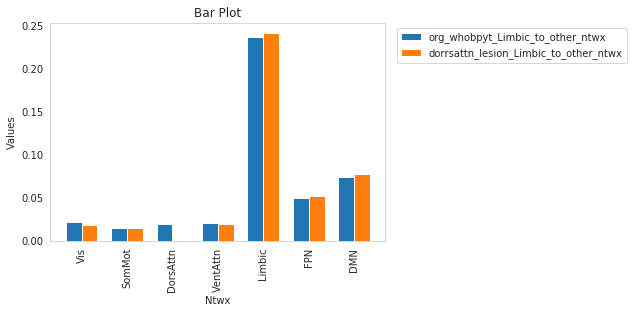

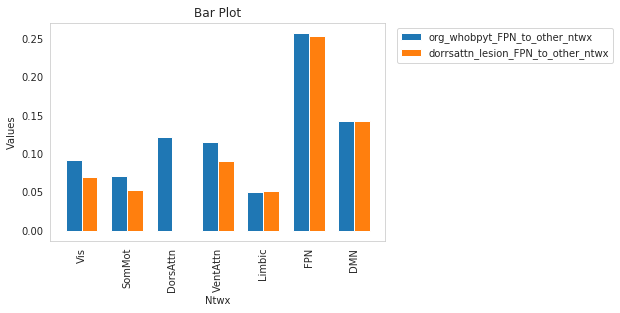

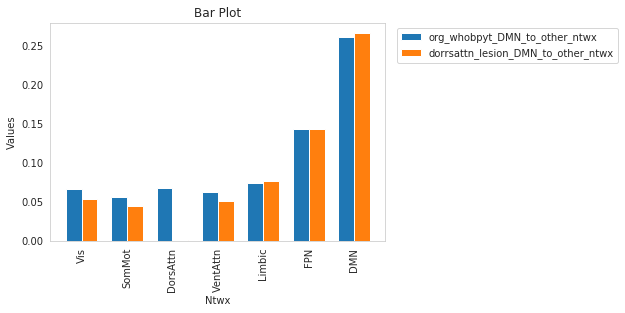

In [63]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx[j], width, label='dorrsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    
    # Displaying the plot
    plt.show()

In [64]:
# og_whobpyt_outer_to_other_ntwx

#### VentAttn

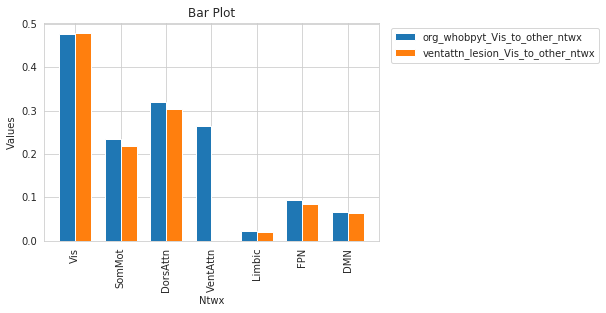

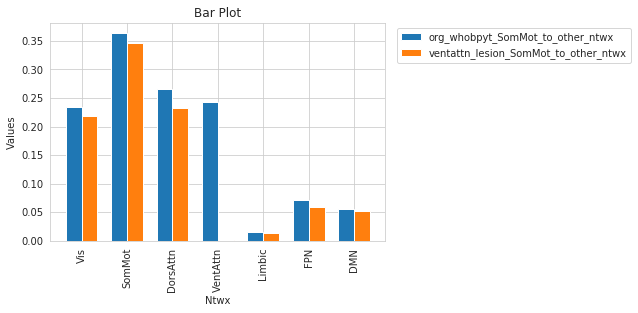

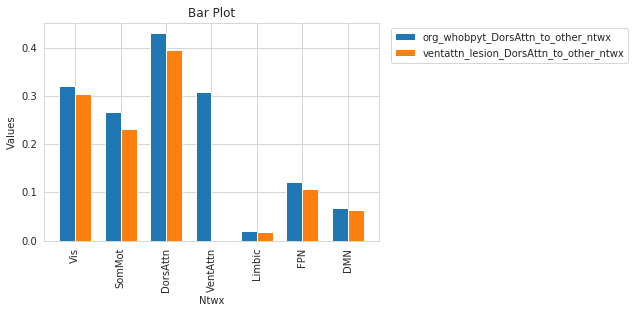

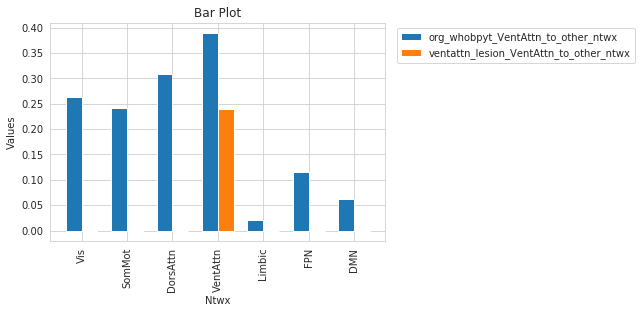

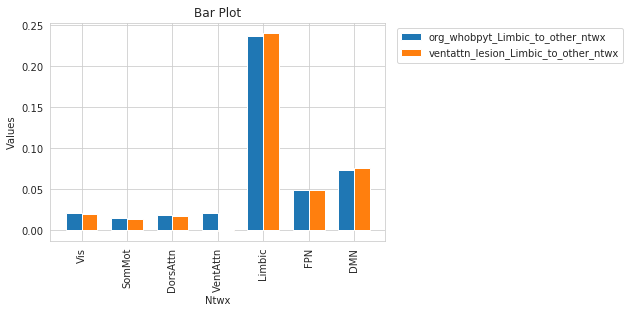

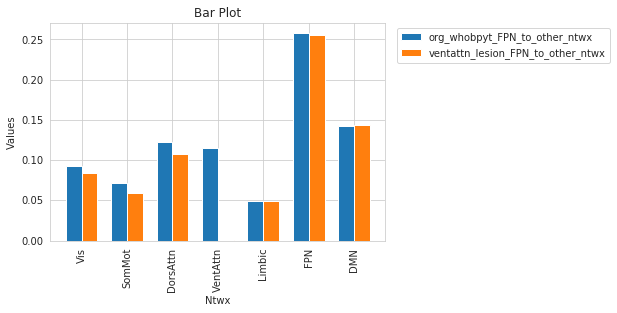

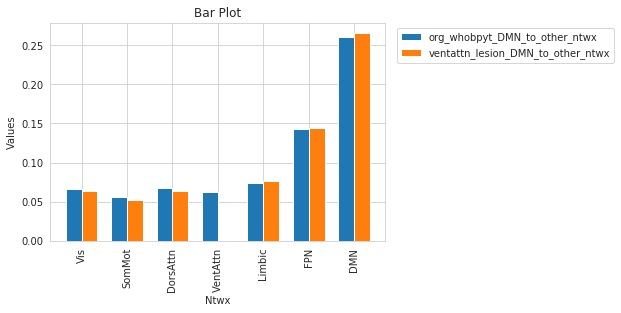

In [65]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx[j], width, label='ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

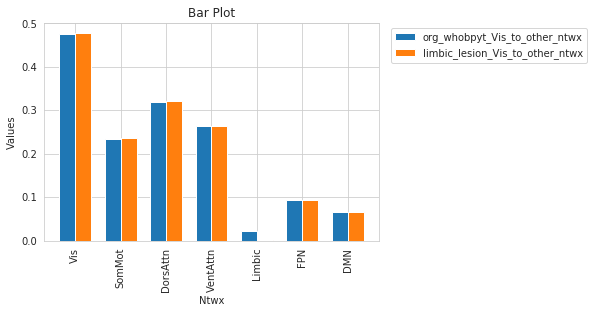

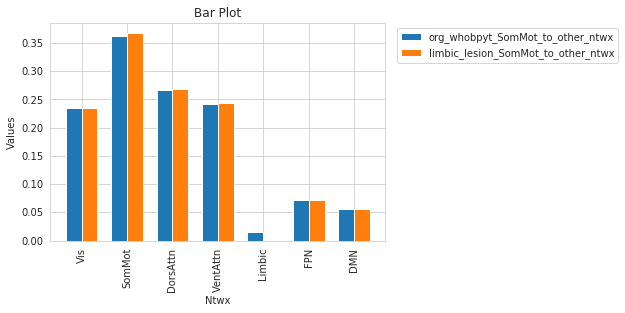

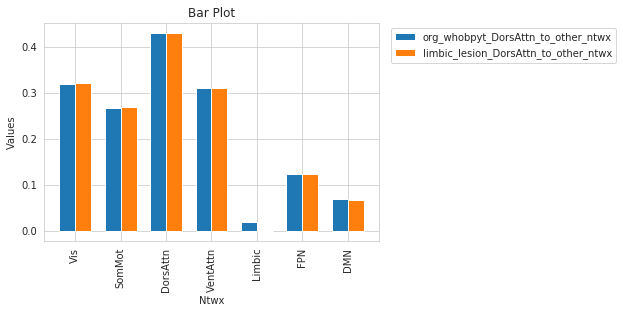

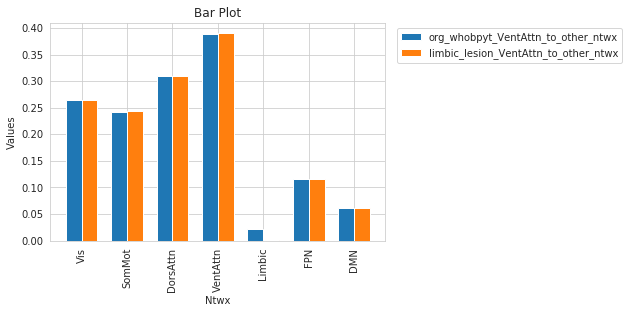

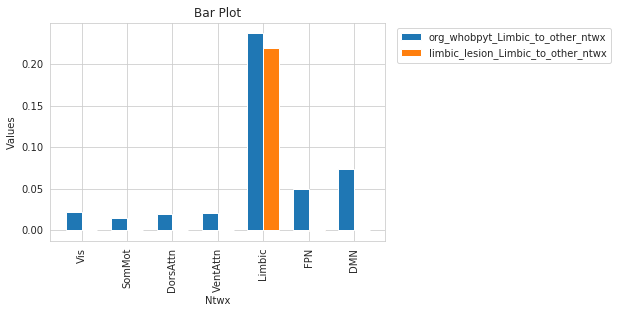

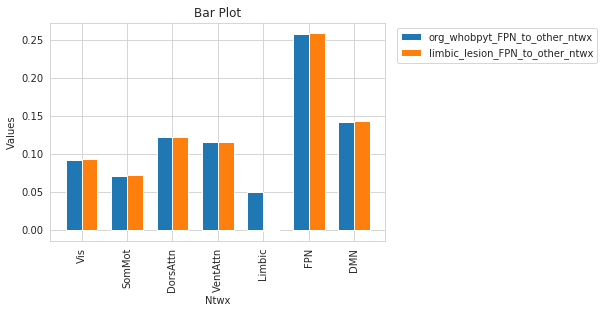

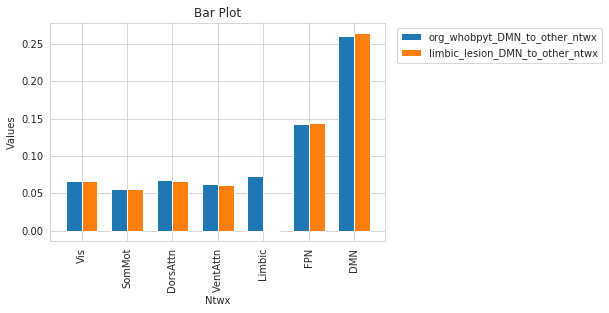

In [66]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx[j], width, label='limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

In [196]:
((0.48592569163858257 - 0.4762078600105418)/0.4762078600105418)*100

2.0406701451390727

In [200]:
((0.3690771616884191- 0.36318165388352663)/0.36318165388352663)*100

1.6232944979052157

In [197]:
og_whobpyt_outer_to_other_ntwx[1]

[0.23502393592845336,
 0.36318165388352663,
 0.26648493938001794,
 0.24247482168102508,
 0.015177268277832891,
 0.07142951488120204,
 0.0560984995220057]

In [198]:
fpn_lesion_outer_to_other_ntwx[1]

[0.2383729158511901,
 0.3690771616884191,
 0.2688250840357927,
 0.24535712657155467,
 0.016050126920157823,
 0.00024135853057225345,
 0.054309780626950264]

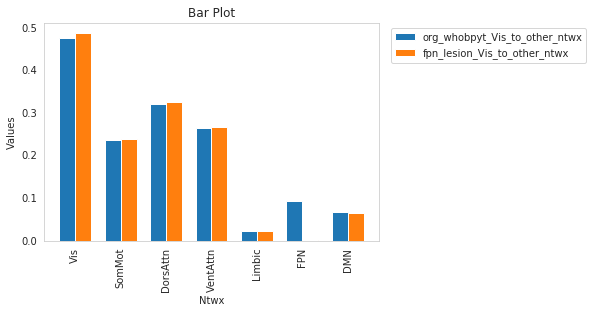

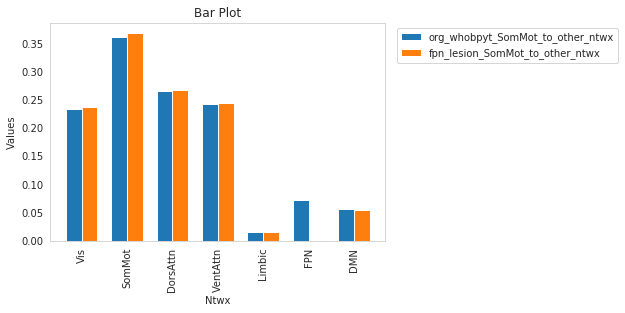

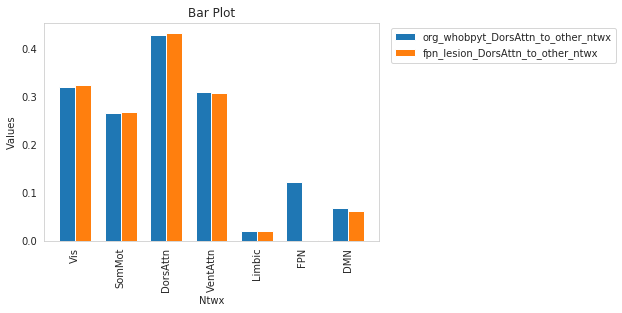

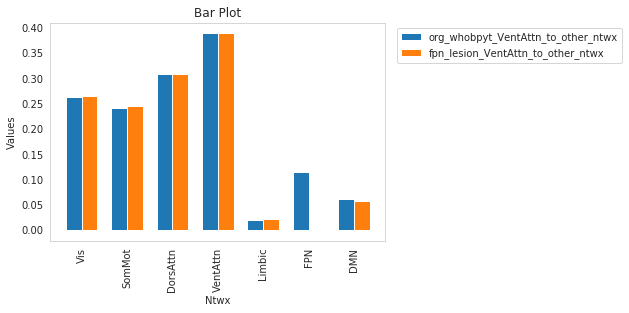

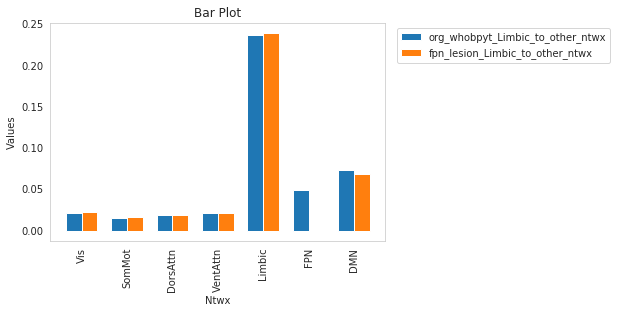

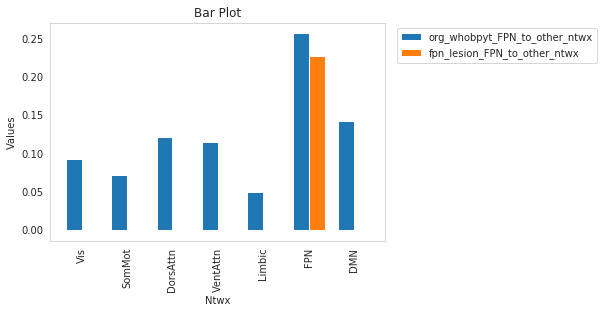

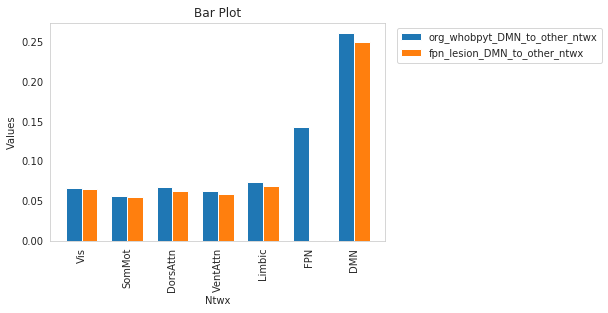

In [50]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx[j], width, label='fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    
    # Displaying the plot
    plt.show()

#### DMN

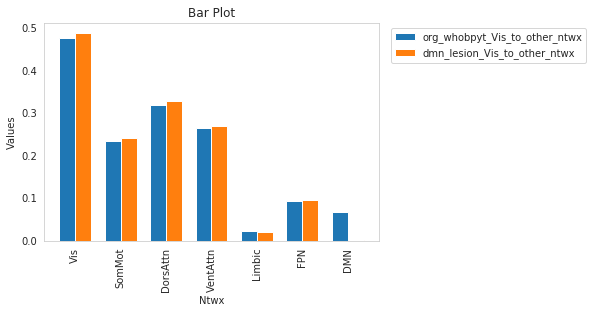

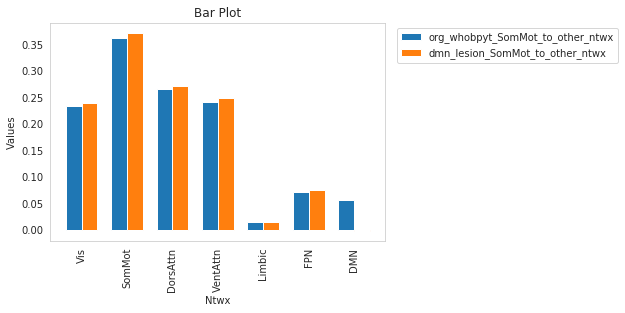

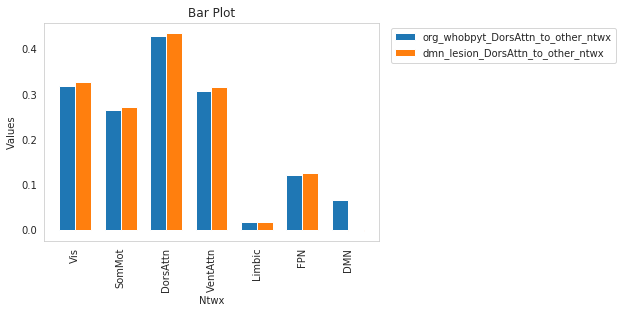

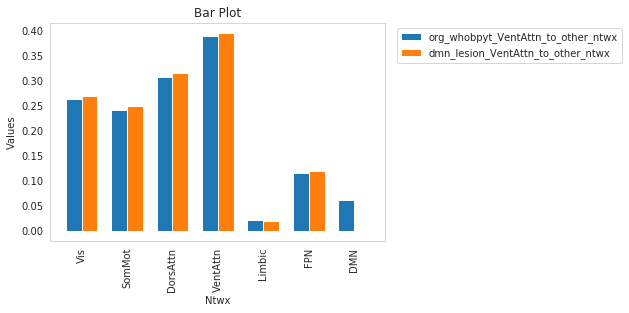

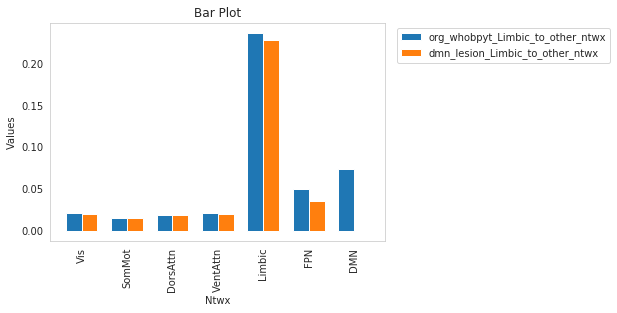

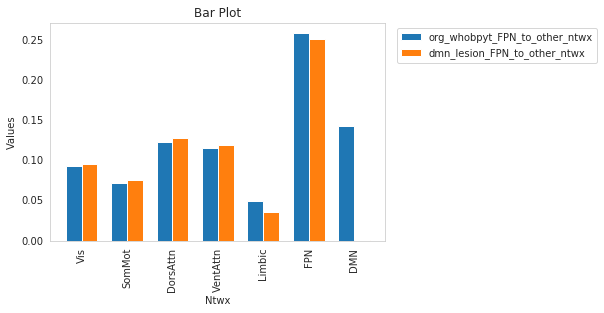

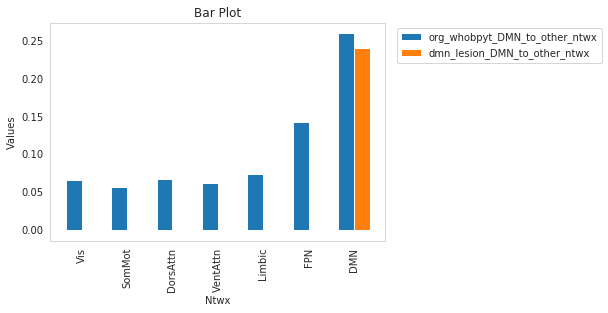

In [152]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx[j], width, label='dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)

    # Displaying the plot
    plt.show()

In [69]:
print(og_whobpyt_outer_to_other_ntwx[6])
print(dmn_lesion_outer_to_other_ntwx[6])

[0.06632744219515917, 0.056098499522005706, 0.06769077653437607, 0.06197428368536091, 0.07339070079829807, 0.14251266026333262, 0.2609094925186769]
[0.00021632063232531785, -0.0012219763536731345, -0.0007077312227832381, -6.872025380525073e-05, -0.00012518171436330184, 0.0007512473613598831, 0.24088748638655652]


### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Stats

In [70]:
Ntwx_labels

['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [71]:
# def stats_ttest_func(list1, list2):
    
#     t_statistic, p_value = stats.ttest_ind(list1, list2)
    
#     # Print the results
# #     print('Network = ', Ntwx_labels[i])
#     print("T-Statistic:", t_statistic)
#     print("P-Value:", p_value)
#     print('-------------------', '\n')

In [72]:
# t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[0], vis_lesion_all_subs_outer_to_other_ntwx[0])

# print(t_stat)

# print(p_val)

### `vis` Lesion Stats

In [121]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = vis_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 0] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 0] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[23.55773128 35.37389676 29.05898072 10.26049696 15.68895214 13.64103248]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[1.80750562e-59 8.99753685e-88 1.57189927e-73 4.25530915e-20
 1.22757720e-36 2.40671491e-30]
--------------------- 

SomMot to other ntwx stats 

[4.5940816  7.56867691 6.80756881 1.93661641 5.85709945 6.23621789]
['0.0000077047', '0.0000000000', '0.0000000001', '0.0542084155', '0.0000000192', '0.0000000026']
[7.70466359e-06 1.37418708e-12 1.14401618e-10 5.42084155e-02
 1.92233113e-08 2.63740485e-09]
--------------------- 

DorsAttn to other ntwx stats 

[7.56867691 8.84375421 8.54712708 2.45030829 5.72060018 6.21369001]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0151373420', '0.0000000385', '0.0000000030']
[1.37418708e-12 4.98296987e-16 3.30803206e-15 1.51373420e-02
 3.85270233e-08 2.97438721e-09]
--------------------- 

VentAttn to other ntwx stats 

[6.80756881 8.54712708 7.197746

### `smt` Lesion Stats

In [122]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = smt_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 1] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 1] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-2.00286894  1.44110177  1.7596195   0.47682915  0.83751994  2.15652329]
['0.0465484044', '0.1511275836', '0.0800089331', '0.6340069785', '0.4033050946', '0.0322422576']
[0.0465484  0.15112758 0.08000893 0.63400698 0.40330509 0.03224226]
--------------------- 

SomMot to other ntwx stats 

[23.6334074  28.14751846 30.46996641  8.09394177 14.37620843 12.68183523]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[1.12855164e-59 2.59602334e-71 7.03187500e-77 5.64000218e-14
 1.31359953e-32 2.13068635e-27]
--------------------- 

DorsAttn to other ntwx stats 

[1.44110177 2.39563511 2.67140622 0.25315493 0.83975712 2.40159451]
['0.1511275836', '0.0175181513', '0.0081788550', '0.8004098217', '0.4020523119', '0.0172434850']
[0.15112758 0.01751815 0.00817886 0.80040982 0.40205231 0.01724348]
--------------------- 

VentAttn to other ntwx stats 

[1.7596195  2.67140622 2.25021107 0.38840927 0.61415076 2.22512083]
['0.080

### `dan` Lesion Stats

In [123]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = dan_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 2] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 2] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[4.40196681 5.60499077 5.80106377 1.76762769 4.83076485 4.08841914]
['0.0000174884', '0.0000000688', '0.0000000256', '0.0786556774', '0.0000027102', '0.0000630037']
[1.74884122e-05 6.88308326e-08 2.56063404e-08 7.86556774e-02
 2.71021997e-06 6.30037109e-05]
--------------------- 

SomMot to other ntwx stats 

[5.60499077 4.07002193 5.2270771  0.30908939 4.69806198 3.90956482]
['0.0000000688', '0.0000677746', '0.0000004336', '0.7575768999', '0.0000048916', '0.0001267567']
[6.88308326e-08 6.77745687e-05 4.33559507e-07 7.57576900e-01
 4.89156528e-06 1.26756735e-04]
--------------------- 

DorsAttn to other ntwx stats 

[35.13091681 28.26605641 40.64223498  9.17668363 21.26430013 14.97779679]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[2.93764436e-87 1.32867432e-71 2.57172704e-98 5.77054666e-17
 4.01307922e-53 1.85708912e-34]
--------------------- 

VentAttn to other ntwx stats 

[5.80106377 5.2270771  5.073525

### `van` Lesion Stats

In [ ]:
van_lesion_all_subs_outer_to_other_ntwx

In [143]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = van_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 3] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 3] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-0.49609399  3.19419493  2.46152467  1.1547737   2.50527725  1.4440588 ]
['0.6203755764', '0.0016304246', '0.0146860042', '0.2495678888', '0.0130375883', '0.1502949659']
[0.62037558 0.00163042 0.014686   0.24956789 0.01303759 0.15029497]
--------------------- 

SomMot to other ntwx stats 

[3.19419493 2.97196771 4.80402584 1.01386772 4.0875216  2.09982772]
['0.0016304246', '0.0033238584', '0.0000030556', '0.3118769875', '0.0000632288', '0.0370042990']
[1.63042457e-03 3.32385843e-03 3.05556213e-06 3.11876987e-01
 6.32288377e-05 3.70042990e-02]
--------------------- 

DorsAttn to other ntwx stats 

[2.46152467 4.80402584 4.36687866 1.15544266 3.79926614 2.26329739]
['0.0146860042', '0.0000030556', '0.0000202561', '0.2492946291', '0.0001927807', '0.0246966775']
[1.46860042e-02 3.05556213e-06 2.02561241e-05 2.49294629e-01
 1.92780718e-04 2.46966775e-02]
--------------------- 

VentAttn to other ntwx stats 

[29.12465983 30.38207972 40.52327889 11.35935923 20.2455

### `lim` Lesion Stats

In [144]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = lim_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 4] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 4] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-0.36362155 -0.05381834 -0.56947858  0.20785751 -0.62880712  0.29103324]
['0.7165266373', '0.9571338831', '0.5696736578', '0.8355527961', '0.5301964441', '0.7713290021']
[0.71652664 0.95713388 0.56967366 0.8355528  0.53019644 0.771329  ]
--------------------- 

SomMot to other ntwx stats 

[-0.05381834 -2.09433975 -0.85409708 -1.28831194 -0.62214391  0.19781296]
['0.9571338831', '0.0374957710', '0.3940781752', '0.1991332948', '0.5345594104', '0.8433933198']
[0.95713388 0.03749577 0.39407818 0.19913329 0.53455941 0.84339332]
--------------------- 

DorsAttn to other ntwx stats 

[-0.56947858 -0.85409708 -0.11236566 -0.36891873 -0.19381626  0.82753717]
['0.5696736578', '0.3940781752', '0.9106467492', '0.7125805048', '0.8465174500', '0.4089239261']
[0.56967366 0.39407818 0.91064675 0.7125805  0.84651745 0.40892393]
--------------------- 

VentAttn to other ntwx stats 

[ 0.20785751 -1.28831194 -0.36891873 -0.08708544 -0.38844471  0.22527995]
['0.8355527961', '0.

### `fpn` Lesion Stats

In [145]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = fpn_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 5] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 5] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-4.03517801 -1.35938635 -1.6051327  -0.79876841 -1.01488134  0.71489194]
['0.0000777700', '0.1755626177', '0.1100503609', '0.4253769877', '0.3113947198', '0.4755136431']
[7.77700020e-05 1.75562618e-01 1.10050361e-01 4.25376988e-01
 3.11394720e-01 4.75513643e-01]
--------------------- 

SomMot to other ntwx stats 

[-1.35938635 -2.65719024 -0.85949907 -1.06071282 -0.70266169  0.9908252 ]
['0.1755626177', '0.0085192788', '0.3910994341', '0.2901060913', '0.4830877488', '0.3229741639']
[0.17556262 0.00851928 0.39109943 0.29010609 0.48308775 0.32297416]
--------------------- 

DorsAttn to other ntwx stats 

[-1.6051327  -0.85949907 -0.79212733  0.11513679  0.04086198  2.14252071]
['0.1100503609', '0.3910994341', '0.4292296813', '0.9084527956', '0.9674468960', '0.0333663047']
[0.11005036 0.39109943 0.42922968 0.9084528  0.9674469  0.0333663 ]
--------------------- 

VentAttn to other ntwx stats 

[-0.79876841 -1.06071282  0.11513679 -0.15011814 -0.5826891   1.62012

### `dmn` Lesion Stats

In [146]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = og_whobpyt_all_subs_outer_to_other_ntwx[i]
    condition_B = dmn_lesion_all_subs_outer_to_other_ntwx[i]
    
    condition_A = [[value for k, value in enumerate(sublist) if k != 6] for sublist in condition_A]
    condition_B = [[value for m, value in enumerate(sublist) if m != 6] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-5.34210301 -3.15054314 -4.31699795 -3.25543912  0.90701029 -2.06396244]
['0.0000002499', '0.0018810828', '0.0000249235', '0.0013306466', '0.3654983326', '0.0403185873']
[2.49938686e-07 1.88108276e-03 2.49235249e-05 1.33064663e-03
 3.65498333e-01 4.03185873e-02]
--------------------- 

SomMot to other ntwx stats 

[-3.15054314 -5.1509502  -3.71497408 -3.85130135  0.48562784 -2.56616549]
['0.0018810828', '0.0000006214', '0.0002639652', '0.0001583619', '0.6277653060', '0.0110181937']
[1.88108276e-03 6.21398128e-07 2.63965189e-04 1.58361924e-04
 6.27765306e-01 1.10181937e-02]
--------------------- 

DorsAttn to other ntwx stats 

[-4.31699795 -3.71497408 -3.55307425 -4.0585893   0.3572219  -3.42420175]
['0.0000249235', '0.0002639652', '0.0004754650', '0.0000709108', '0.7213042279', '0.0007487027']
[2.49235249e-05 2.63965189e-04 4.75465019e-04 7.09108024e-05
 7.21304228e-01 7.48702708e-04]
--------------------- 

VentAttn to other ntwx stats 

[-3.25543912 -3.851

In [225]:
_var2 = [vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [226]:
array_var2 = np.array(_var2)

In [227]:
array_var2.shape

(7, 7, 7)

In [234]:
from mpl_toolkits.mplot3d import Axes3D

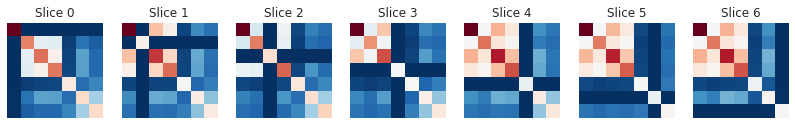

In [247]:
fig, axs = plt.subplots(1, 7, figsize=(14, 16))  # Assuming you want to display 7 slices
for i in range(7):
    axs[i].imshow(array_var2[i, :, :], cmap='RdBu_r')  # Adjust the colormap as needed
    axs[i].axis('off')
    axs[i].set_title(f'Slice {i}')

plt.show()

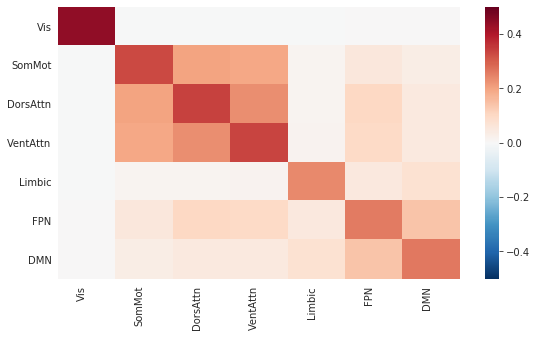

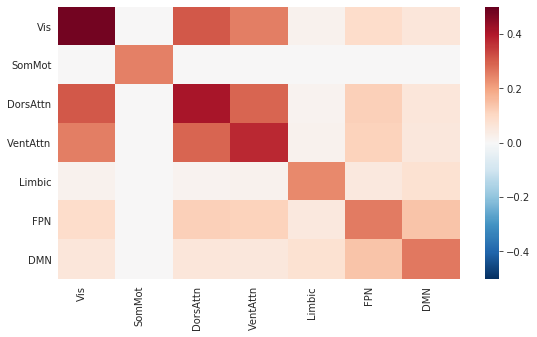

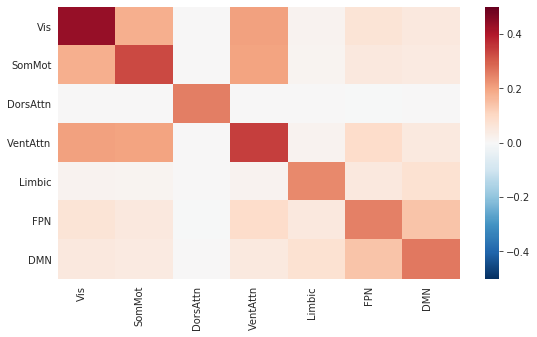

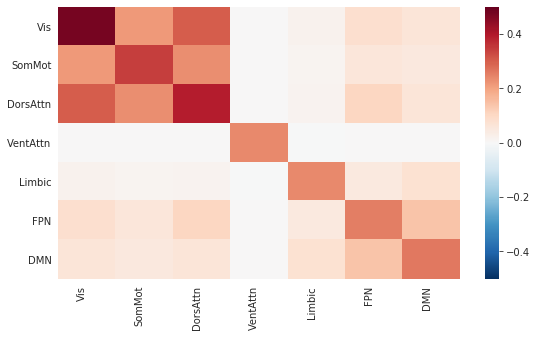

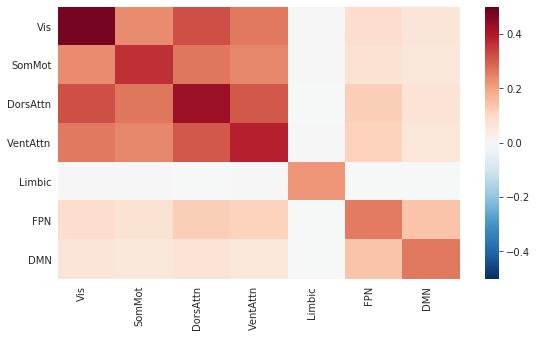

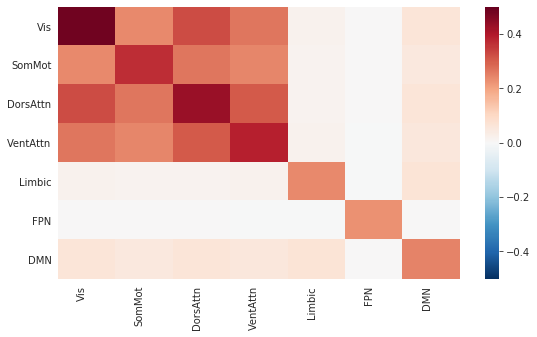

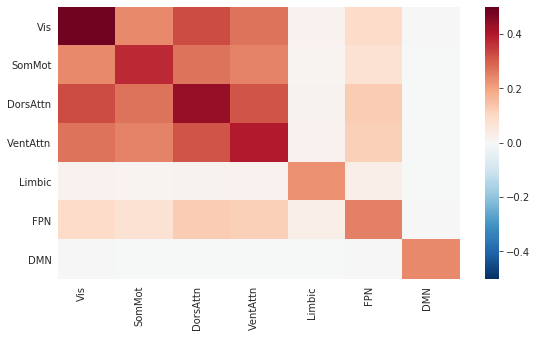

In [274]:
for i in range(7):
    fig, ax = plt.subplots(figsize=(9,5))
    sns.heatmap(array_var2[i,:,:],cmap='RdBu_r',center=0, vmin=-0.5, vmax = 0.5)
#     im = ax.imshow(array_var2[i, :, :], cmap='RdBu_r')  
#     cbar = plt.colorbar(im, ax=ax, ticks=np.linspace(vmin, vmax, 11))
    ax.set_xticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_xticklabels(Ntwx_labels, rotation=90, ha='right')
    ax.set_yticks(np.arange(len(Ntwx_labels)) + 0.5)
    ax.set_yticklabels(Ntwx_labels, rotation=0, ha='right')
    plt.show()


In [275]:
Ntwx_labels

['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']